Author Note: this is an exploratory notebook workshoping the author's pipeline -- for the paper's main pipeline please use "train.ipynb" and then "evaluation_benchmark.ipynb" followed by "visualize_benchmark_results.ipynb"

Please see cell [3] of "evaluation_benchmark.ipynb" for the definition of a SCOD model.

See "init_scod" at line 320 of utils.py for the hyperparameters used to define our OOD wrapper.

In [ ]:
%load_ext autoreload
%autoreload 2

import scod
import numpy as np
from matplotlib import pyplot as plt
from scripts.train_functions import create_dataloaders, load_model_from_ckp
from scripts.utils import sample_pred_scod

Clear GPU usage

In [2]:
import torch
torch.cuda.empty_cache()

## Exoromper

In [3]:
dataset_path = 'datasets/exoromper/'
batch = 20
dataloaders, dataset_sizes = create_dataloaders(dataset_path, batch, dataset_name="exoromper")


Load a trained model

In [4]:
load_model_path = './best_model/ex_v5_best_model.pt'
model, optimizer, start_epoch_idx, valid_loss, criterion, device = load_model_from_ckp(load_model_path)

In [5]:
# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=1.)

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [6]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 2,
    'sketch_type': 'srft',
}, parameters=list(model.parameters())[-4:])

<class 'scod.sketching.sketched_pca.SRFT_SinglePassPCA'>


In [7]:
unc_model.process_dataloader(dataloaders['space'])

computing basis
using T = 16


 38%|███▊      | 6/16 [00:04<00:07,  1.39it/s]


Loop over all the different dataloaders, get batch of images, store true labels, run through unc, store the yhats and sigs


In [8]:
# dnames = ['train','val','test']
dnames = ['space','earth','lens_flare']

In [10]:
sample_pred_scod(dnames, dataloaders, model, unc_model)

Sampling from dataset:  space
Sampling from dataset:  earth
Sampling from dataset:  lens_flare
Saved to file:  saved_data/20220820-142751


In [11]:
# Load from file
# filename= 'saved_data/' + '20220429-010710.npz' # Includes model predictions for v1 (train, test, val)
# filename= 'saved_data/' + '20220429-030639.npz' # Includes model predictions for v2 (space, earth, lens_flare)
filename= 'saved_data/' + '20220820-142751.npz' # Includes model predictions for v5 (space, earth, lens_flare)


loaded = np.load(filename,allow_pickle=True)
true_labels = loaded['true_labels'].item()
pred_labels = loaded['pred_labels'].item()
pred_mean = loaded['pred_mean'].item()
pred_stddev = loaded['pred_stddev'].item()
uncertainties = loaded['uncertainties'].item()

Plot the MSE (true vs. pred labels) for all dataloaders


In [12]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

[Text(0, 0.5, 'Mean squared error'), Text(0.5, 0, 'Dataset noise')]

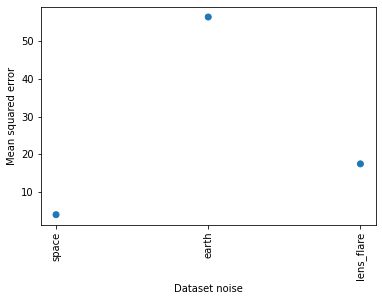

In [13]:
dnlabels = dnames

mse = np.zeros(np.shape(dnames))
mkrcolors = []
for i, dn in enumerate(dnames):
    mse[i] = np.mean(reject_outliers( np.sum( (true_labels[dn] - pred_labels[dn])**2, axis=-1)) )
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')
        
fig, ax = plt.subplots()
ax.scatter(np.arange(len(dnames)), mse, color=mkrcolors)
# ax.scatter(np.arange(len(dnames)), mse_old, color='r')

ax.xaxis.set_ticks(np.arange(len(dnames)))
ax.xaxis.set_ticklabels(dnlabels, rotation=90)
ax.set(ylabel='Mean squared error', xlabel='Dataset noise')

# plt.savefig('plots_images/MSE_trend.png', dpi=200)

Plot the sigs for all dataloaders

[Text(0, 0.5, 'Model uncertainty'), Text(0.5, 0, 'Dataset noise')]

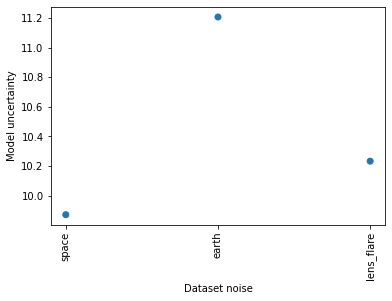

In [14]:
dnlabels = dnames

uncertainty = np.zeros(np.shape(dnames))
mkrcolors = []
for i, dn in enumerate(dnames):
    uncertainty[i] = np.mean(uncertainties[dn])
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')

fig, ax = plt.subplots()
ax.scatter(np.arange(len(dnames)), uncertainty, color=mkrcolors)
ax.xaxis.set_ticks(np.arange(len(dnames)))
ax.xaxis.set_ticklabels(dnlabels, rotation=90)
ax.set(ylabel='Model uncertainty', xlabel='Dataset noise')

# plt.savefig('plots_images/Model_uncertainty_trend_3.png', dpi=200)

Model select threshold for OOD

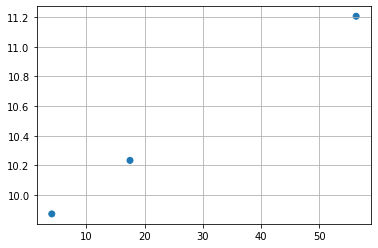

In [15]:
dnlabels = dnames

mse = np.zeros(np.shape(dnames))
uncertainty = np.zeros(np.shape(dnames))

mkrcolors = []
for i, dn in enumerate(dnames):
    mse[i] = np.mean( reject_outliers(np.sum( (true_labels[dn] - pred_labels[dn])**2, axis=-1) ))
    uncertainty[i] = np.mean(uncertainties[dn])
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')
        
fig, ax = plt.subplots()
ax.scatter(mse, uncertainty, color=mkrcolors)
# # Best fit line
# m, b = np.polyfit(mse, uncertainty, 1)
# xvals = np.linspace(0, 25, 5)
# ax.plot(xvals, m*xvals + b-0.0015, ls=(0, (5,5)), color='k')

# ax.set(ylabel='Model uncertainty', xlabel='Pose estimation error')
ax.grid()

# ax.axvline(x=10, color='teal', ls = '--')
# ax.axhline(y=0.935, color='red', ls = '--')

# plt.savefig('plots_images/threshold.png', dpi=200)
# plt.savefig('plots_images/threshold_with_bestfit.png', dpi=200)

## Speed dataset

In [3]:
dataset_path = 'datasets/speed/'
batch = 20
dataloaders, dataset_sizes = create_dataloaders(dataset_path, batch)


Load a trained model

In [4]:
load_model_path = './best_model/images_1000_utils_best_model.pt'
model, optimizer, start_epoch_idx, valid_loss, criterion, device = load_model_from_ckp(load_model_path)

CUDA IS AVAILABLE?  True


In [5]:
# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=1.)

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [6]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 2,
    'sketch_type': 'srft',
}, parameters=list(model.parameters())[-4:])

<class 'scod.sketching.sketched_pca.SRFT_SinglePassPCA'>


In [7]:
unc_model.process_dataloader(dataloaders['train'])

computing basis
using T = 16


36it [00:04,  7.21it/s]                        


In [8]:
unc_model.calibrate_dataloader(dataloaders['val'], 0.95)

100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


Loop over all the different dataloaders, get batch of images, store true labels, run through unc, store the yhats and sigs


In [10]:
dnames = ['train','val','test', 'test_0001', 'test_0005', 'test_001', 'test_01', 'test_10', 'test_50', 'test_90']

In [11]:
# sample_pred_scod(dnames, dataloaders, model, unc_model)

Sampling from dataset:  train
Sampling from dataset:  val
Sampling from dataset:  test
Sampling from dataset:  test_0001
Sampling from dataset:  test_0005
Sampling from dataset:  test_001
Sampling from dataset:  test_01
Sampling from dataset:  test_10
Sampling from dataset:  test_50
Sampling from dataset:  test_90
Saved to file:  saved_data/20220429-032404


In [11]:
# Load from file
# filename= 'saved_data/' + '20220218-024328.npz' # Not calibrated with val
# filename= 'saved_data/' + '20220218-033505.npz' # Calibrated with val
filename= 'saved_data/' + '20220218-040324.npz' # Includes model predictions

loaded = np.load(filename,allow_pickle=True)
true_labels = loaded['true_labels'].item()
pred_labels = loaded['pred_labels'].item()
pred_mean = loaded['pred_mean'].item()
pred_stddev = loaded['pred_stddev'].item()
uncertainties = loaded['uncertainties'].item()

Plot the MSE (true vs. pred labels) for all dataloaders


[Text(0, 0.5, 'Mean squared error'), Text(0.5, 0, 'Dataset noise')]

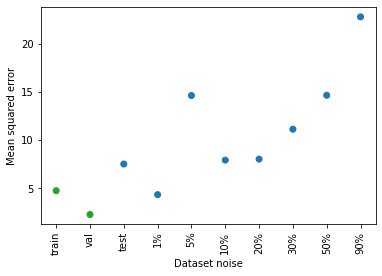

In [12]:
dnames = ['train','val','test', 'test_0001', 'test_0005', 'test_001', 'test_01', 'test_10', 'test_50', 'test_90']
dnlabels = ['train', 'val', 'test', '1%','5%', '10%', '20%', '30%', '50%', '90%']

mse_old = np.zeros(np.shape(dnames))
mse = np.zeros(np.shape(dnames))
mkrcolors = []
for i, dn in enumerate(dnames):
    mse_old[i] = np.mean( np.sum( (true_labels[dn] - pred_mean[dn])**2, axis=-1) )
    mse[i] = np.mean( np.sum( (true_labels[dn] - pred_labels[dn])**2, axis=-1) )
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')
        
fig, ax = plt.subplots()
ax.scatter(np.arange(len(dnames)), mse, color=mkrcolors)
# ax.scatter(np.arange(len(dnames)), mse_old, color='r')

ax.xaxis.set_ticks(np.arange(len(dnames)))
ax.xaxis.set_ticklabels(dnlabels, rotation=90)
ax.set(ylabel='Mean squared error', xlabel='Dataset noise')

# plt.savefig('plots_images/MSE_trend.png', dpi=200)

Plot the sigs for all dataloaders

[Text(0, 0.5, 'Model uncertainty'), Text(0.5, 0, 'Dataset noise')]

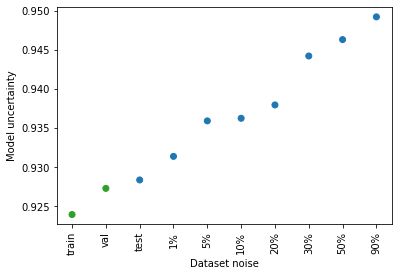

In [13]:
dnames = ['train','val','test', 'test_0001', 'test_0005', 'test_001', 'test_01', 'test_10', 'test_50', 'test_90']
dnlabels = ['train', 'val', 'test', '1%','5%', '10%', '20%', '30%', '50%', '90%']

uncertainty = np.zeros(np.shape(dnames))
mkrcolors = []
for i, dn in enumerate(dnames):
    uncertainty[i] = np.mean(uncertainties[dn])
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')

fig, ax = plt.subplots()
ax.scatter(np.arange(len(dnames)), uncertainty, color=mkrcolors)
ax.xaxis.set_ticks(np.arange(len(dnames)))
ax.xaxis.set_ticklabels(dnlabels, rotation=90)
ax.set(ylabel='Model uncertainty', xlabel='Dataset noise')

# plt.savefig('plots_images/Model_uncertainty_trend_3.png', dpi=200)

Model select threshold for OOD

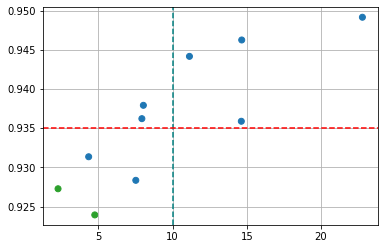

In [14]:
dnames = ['train','val','test', 'test_0001', 'test_0005', 'test_001', 'test_01', 'test_10', 'test_50', 'test_90']
dnlabels = ['train', 'val', 'test', '1%','5%', '10%', '20%', '30%', '50%', '90%']

mse = np.zeros(np.shape(dnames))
uncertainty = np.zeros(np.shape(dnames))

mkrcolors = []
for i, dn in enumerate(dnames):
    mse[i] = np.mean( np.sum( (true_labels[dn] - pred_labels[dn])**2, axis=-1) )
    uncertainty[i] = np.mean(uncertainties[dn])
    if dn == 'train' or dn == 'val':
        mkrcolors.append('C2')
    else:
        mkrcolors.append('C0')
        
fig, ax = plt.subplots()
ax.scatter(mse, uncertainty, color=mkrcolors)
# # Best fit line
# m, b = np.polyfit(mse, uncertainty, 1)
# xvals = np.linspace(0, 25, 5)
# ax.plot(xvals, m*xvals + b-0.0015, ls=(0, (5,5)), color='k')

# ax.set(ylabel='Model uncertainty', xlabel='Pose estimation error')
ax.grid()

ax.axvline(x=10, color='teal', ls = '--')
ax.axhline(y=0.935, color='red', ls = '--')

# plt.savefig('plots_images/threshold.png', dpi=200)
# plt.savefig('plots_images/threshold_with_bestfit.png', dpi=200)